In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from drone_sac import AgentParallel, BufferParallel
from drone_gym import DroneGym
from tqdm.notebook import tqdm
import torch as T

<frozen importlib._bootstrap>:219: RuntimeWarning: easyvec.vectors.Vec3 size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject


In [2]:
from distributed import Client, LocalCluster

cl = Client(LocalCluster(n_workers=30, threads_per_worker=1))
cl

Client Scheduler: tcp://127.0.0.1:61970 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 30 Cores: 30 Memory: 63.93 GiB


In [3]:
def generate_data(n_points):
    try:
        import sys
        sys.path.append(r'D:\neuro_missile\src\cydrone')
        sys.path.append(r'D:\neuro_missile\src')
        import numpy as np
        from drone_sac import AgentParallel, BufferParallel
        from drone_gym import DroneGym
        
        import pickle
        with open('agent_dict.bin', 'rb') as f:
            agent_dict = pickle.load(f)
        
        env = DroneGym.make()
        agent = AgentParallel(
            input_dims=env.obs_max.shape, 
            n_actions=2, 
            action_space_high=env.action_space.high)
#             device_name='cpu')
        agent.from_dict(agent_dict)
        buffer = BufferParallel(agent)

        env.record_history = False
        env.antiflip = True
        n = 0
        while True:
            observation = env.reset()
            done = False
            while not done:
#                 action = agent.choose_action(observation)
                action = np.random.uniform(0.97,1, size=2)
                observation_, reward, done, info = env.step(action)
                buffer.store_transition(observation, action, reward, observation_, done)
                observation = observation_
                n += 1
                if n >= n_points:
                    return True, buffer.to_dict()
    except Exception as e:
        return False, {'error': str(e)}
    
    

In [4]:
env = DroneGym.make()

In [5]:
agent = AgentParallel(input_dims=env.obs_max.shape, n_actions=2, action_space_high=env.action_space.high)
agent2 = AgentParallel(input_dims=env.obs_max.shape, n_actions=2, action_space_high=env.action_space.high, device_name='cpu')

In [6]:
buffer = BufferParallel(agent)

In [7]:
d = agent.to_dict()

In [8]:
import pickle
with open('agent_dict.bin', 'wb') as f:
    pickle.dump(d, f)

In [9]:
n_workers = 60
n_pointss = [1000] * n_workers

futs = cl.map(generate_data, n_pointss, pure=False)

In [23]:
futs[0].result()

(True,
 {'state_memory_list': [array([0.67953239, 0.47945865, 0.84140486, 0.36154038, 0.48512292,
          0.03655422, 0.50015546, 0.25675682, 0.91494321]),
   array([0.67957982, 0.47955768, 0.79750032, 0.36154754, 0.48501816,
          0.05428931, 0.50012434, 0.25675682, 0.91494894]),
   array([0.67964959, 0.47969677, 0.77611234, 0.36155409, 0.48487024,
          0.07379269, 0.50023112, 0.25675682, 0.91495777]),
   array([0.67974121, 0.47984776, 0.76390357, 0.36156002, 0.48470739,
          0.09342958, 0.50019345, 0.25675682, 0.91496963]),
   array([0.67985442, 0.4800495 , 0.75594446, 0.36156535, 0.48449081,
          0.11355733, 0.50032737, 0.25675682, 0.91498447]),
   array([0.67998921, 0.48030818, 0.75039003, 0.3615701 , 0.48421429,
          0.13369596, 0.50037242, 0.25675682, 0.91500231]),
   array([0.68014535, 0.480588  , 0.7463208 , 0.36157431, 0.48391368,
          0.15368257, 0.50039188, 0.25675682, 0.9150231 ]),
   array([0.68032228, 0.48088854, 0.74319566, 0.36157801, 0.48

In [81]:
score = 0
env.record_history = True
env.antiflip = True
for i in tqdm(range(150)):
    observation = env.reset()
    done = False
    score = 0
    while not done:
#         action = np.random.uniform(0.97,1, size=2)
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        buffer.store_transition(observation, action, reward, observation_, done)
        observation = observation_
#     buffer.refresh()
#     for batch in buffer.iter_batches(2048):
#         agent.learn(*batch)

  0%|          | 0/150 [00:00<?, ?it/s]

In [75]:
buffer.refresh()

49187

In [71]:
for i in tqdm(range(130)):
    buffer.refresh()
    for batch in buffer.iter_batches(1024*16):
        agent.learn(*batch)

  0%|          | 0/130 [00:00<?, ?it/s]

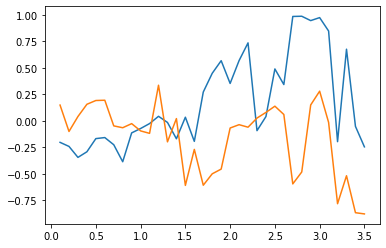

In [73]:
from ipywidgets import interact, interactive, fixed
import ipywidgets
import matplotlib.pyplot as plt
gym = env

xs = []
ys = []
f1s = []
f2s = []
rewards = []
ts = []
dts = []
scores = [0]
for d in gym.history:
    gym.set_state(d['state'])
    xs.append(gym.drone.pos.x)
    ys.append(gym.drone.pos.y)
    f1, f2 = d['actions']
    f1s.append(f1)
    f2s.append(f2)
    ts.append(gym.time_curr)
    rewards.append(d['reward'])
    dts.append(d['delta_t1'])
    scores.append(scores[-1]+d['reward'])
scores = scores[1:]
i1=0
i2=-1
# plt.plot(ts[i1:i2], rewards[i1:i2])
plt.plot(ts[i1:i2], f1s[i1:i2])
plt.plot(ts[i1:i2], f2s[i1:i2])
# plt.plot(ts[i1:i2], dts[i1:i2])

In [74]:
@interact(i=ipywidgets.IntSlider(min=0,max=len(gym.history)-1,step=1, value=0))
def plot_history(i):
    d = gym.history[i]
    i1=max(0,i-30)
    i2=i+1
    gym.set_state(d['state'])
    fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(14,7))
    gym.plot(ax, drone_mashtb=20, vec_mashtb=1, actions=d['actions'],ideal_traj=True)
    ax.plot(xs[i1:i],ys[i1:i],ls=':')
    ax.set_aspect('equal', adjustable='box')
    
    
#     ax2.plot(ts[i1:i2], f1s[i1:i2])
#     ax2.plot(ts[i1:i2], f2s[i1:i2])
    ax2.grid()
    ax2.plot(ts[:i2], scores[:i2])
    
    ax3.plot(ts[:i2], rewards[:i2])
    ax3.grid()
    ax.grid()
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=35), Output()), _dom_classes=('widget-interact',…